# -- Objetivo do problema
    
    --1.0. Previsão do primeiro destino que um novo usuário irá escolher.
    
    --Por que?
        --Quak tipo de modelo de negócio do Airbnb
            --Marketplace( Conecta pessoas que oferecem acamodação, com pessoas que estão procurando acomodação )
            --Oferta ( pessoas oferecendo acomodação )
                -- Tamanho do portfolio
                -- Diversidade/densidade de portfolio.
                -- Preço Médio
                
            -- Demanda ( pessoas procurando acomodação )
                -- Numero de Usuários
                -- LTV ( Lifetime Value )
                -- CAC ( Client acquisition cost )
                
            -- Gross Revenue = (phi*Numero cliente) - CAC
                
            -- Demanda ( pessoas procurando acomodação )
            
--Proposta da solução
  - Modelo de previsão do primeiro destino de um novo usuário.
  - 1.0. Predições e salvar em uma tabela do banco de dados.
  - 2.0. API
        - Input: usuário e suas caracteristicas
        - output: usuario e suas caracteristicas com a coluna prediction

# 0.0. Imports 

In [64]:
import random

import pandas  as pd 
import numpy   as np 
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing   import OneHotEncoder
from sklearn.metrics         import classification_report, accuracy_score, balanced_accuracy_score, cohen_kappa_score
from scikitplot.metrics      import plot_confusion_matrix

from imblearn                import under_sampling, over_sampling 
from imblearn.combine        import SMOTETomek

from scipy.stats             import skewnorm
from scipy                   import stats

from keras import models
from keras import layers

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [13, 8]

sns.set_style('darkgrid')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 0.1. Helper Functions 

In [3]:
def numeric_statistics( df ):
    
    dic = {
        "type": df.dtypes.values,
        "Unique_Values": df.nunique().values,
        "Mean": df.mean(),
        "Median": df.median(),
        "Std": df.std(),
        "Min": df.min(),
        "Max": df.max(),
        "Range": df.max() - df.min(),
        "Skew": df.skew(),
        "Kurtosis": df.kurtosis()
    }
    
    return pd.DataFrame( dic, index=df.columns )

def cramer_v( x, y ):
    
    cm   = pd.crosstab( x, y ).values
    n    = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr    = k - (k-1)**2/(n-1)
    rcorr    = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min(kcorr-1,rcorr-1) ) )

# 1.0. Data Description

In [4]:
# df users
df_raw = pd.read_csv( 'data/train_users_2.csv', low_memory=True )

# df sessions
df_sessions = pd.read_csv( 'data/sessions.csv', low_memory=True )


## Users

In [5]:
df_raw.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.000,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.000,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US



## Sessions

In [6]:
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.000
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.000
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.000
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.000
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.000


## 1.1. Data Dimension  


## Users

In [7]:
print(f'Number of Rows: {df_raw.shape[0]}') 
print(f'Number of Columns: {df_raw.shape[1]}') 

Number of Rows: 213451
Number of Columns: 16



## Sessions

In [8]:
print(f'Number of Rows: {df_sessions.shape[0]}') 
print(f'Number of Columns: {df_sessions.shape[1]}') 

Number of Rows: 10567737
Number of Columns: 6


## 1.2. Data types 


## Users

In [9]:
df_raw.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object


## Sessions

In [10]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3. Check NA 


## Users

In [11]:
df_raw.isnull().sum() / len(df_raw)

id                        0.000
date_account_created      0.000
timestamp_first_active    0.000
date_first_booking        0.583
gender                    0.000
age                       0.412
signup_method             0.000
signup_flow               0.000
language                  0.000
affiliate_channel         0.000
affiliate_provider        0.000
first_affiliate_tracked   0.028
signup_app                0.000
first_device_type         0.000
first_browser             0.000
country_destination       0.000
dtype: float64


## Sessions 

In [12]:
df_sessions.isnull().sum() / len(df_sessions)

user_id         0.003
action          0.008
action_type     0.107
action_detail   0.107
device_type     0.000
secs_elapsed    0.013
dtype: float64

## 1.4. FillNA

### 1.4.1 Users 


## Costumers
If the customer didn't have a country destination, they didn't book an apartment to travel to, my solution to this variable is going to be to exchange the NA values for the max date from a first booking. 

## Age
for this variable I decided to fill the null values with a distribution with the same patterns as the variable age.

In [13]:
# date_first_booking
aux = df_raw[df_raw['date_first_booking'].isna()]

aux['country_destination'].value_counts( normalize=True )

NDF   1.000
Name: country_destination, dtype: float64

NDF     0.768
US      0.157
other   0.029
FR      0.015
IT      0.009
GB      0.006
ES      0.006
CA      0.004
DE      0.002
NL      0.002
AU      0.001
PT      0.001
Name: country_destination, dtype: float64 


Skew: 2.0836975941236724
std: 13.937022241038116
mean: 37.42839144565261


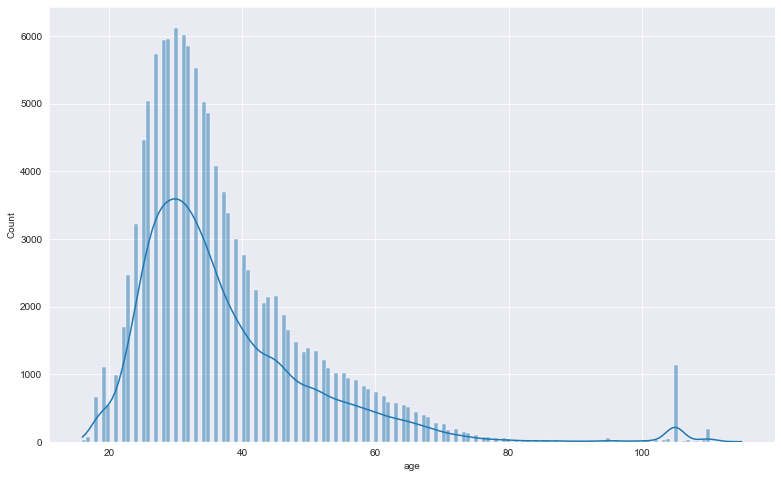

In [14]:
# age
aux = df_raw[df_raw['age'].isna()]
print( aux['country_destination'].value_counts( normalize=True ), '\n\n')

aux_02 = df_raw[( df_raw['age'] > 15 ) & ( df_raw['age'] <120 )]['age']
skew = aux_02.skew()
print(f'Skew: {skew}')

std = aux_02.std()
print(f'std: {std}')

mean = aux_02.mean()
print(f'mean: {mean}')

sns.histplot( aux_02, kde=True );

In [15]:
# date_first_booking
date_first_booking_max = pd.to_datetime( df_raw['date_first_booking'] ).max().strftime( '%Y-%m-%d' )
df_raw['date_first_booking'] = df_raw['date_first_booking'].fillna( date_first_booking_max )

# age
df_raw['age'] = df_raw['age'].apply(lambda x: skewnorm.rvs( skew, loc=mean, scale=std ).astype( 'int64' ) if pd.isna(x) else x )

# first_affiliate_tracked
df_raw = df_raw[~df_raw['first_affiliate_tracked'].isna()]

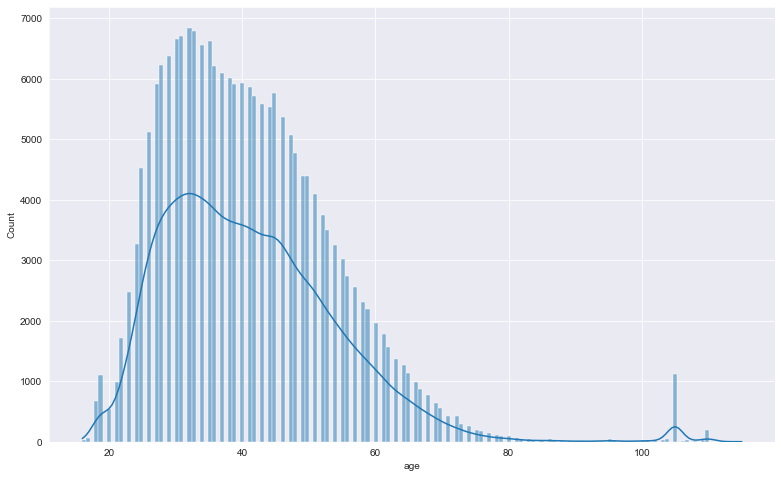

In [16]:
sns.histplot( df_raw[(df_raw['age'] > 15) & (df_raw['age'] <120)]['age'], kde=True );

### 1.4.2 df_sessions

In [17]:
# user_id 0.3%
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

# action - 0.7%
df_sessions = df_sessions[~df_sessions['action'].isna()]

#action_type - 11%
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

# action_details - 11%
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

# secs_elapsed - 1.2%
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

## 1.5. Change Data Types 

In [18]:
aux_01 = df_raw.sample().T
aux_02 = df_raw.sample().dtypes

pd.concat( [aux_01,aux_02], axis=1 )

,143610,0
id,6grwoxve4b,object
date_account_created,2014-01-19,object
timestamp_first_active,20140119100427,int64
date_first_booking,2015-06-29,object
gender,-unknown-,object
age,54.000,float64
signup_method,basic,object
signup_flow,0,int64
language,en,object
affiliate_channel,content,object


In [19]:
# df_raw
# date_account_created
df_raw['date_account_created'] = pd.to_datetime( df_raw['date_account_created'] )

# timestamp_first_active
df_raw['timestamp_first_active'] = pd.to_datetime( df_raw['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date first_booking 
df_raw['date_first_booking'] = pd.to_datetime( df_raw['date_first_booking'] )  
# age 
df_raw['age'] = df_raw['age'].apply( lambda x: x if pd.isna(x) else int(x) )

## 1.6. Check Blanced Data

In [20]:
df_raw['country_destination'].value_counts( )

NDF      120216
US        61067
other      9981
FR         4899
IT         2791
GB         2295
ES         2213
CA         1391
DE         1041
NL          751
AU          527
PT          214
Name: country_destination, dtype: int64

## 1.7. Numerical data 

### 1.7.1 Users

In [21]:
# df_raw
num_attributes = df_raw.select_dtypes( include=['int64','float64'] )
cat_attributes = df_raw.select_dtypes( include='object')
time_attributes = df_raw.select_dtypes( include='datetime64[ns]')

numeric_statistics( num_attributes )

,type,Unique_Values,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
age,int64,129,48.341,40.000,118.589,1,2014,2013,16.286,266.595
signup_flow,int64,17,3.151,0.000,7.544,0,25,25,2.287,3.568


### 1.7.2 Sessions

In [22]:
# df_sessions
num_attributes_sessions = df_sessions.select_dtypes( include=['int64','float64'] )
cat_attributes_sessions = df_sessions.select_dtypes( include='object')
time_attributes_sessions = df_sessions.select_dtypes( include='datetime64[ns]')

numeric_statistics( num_attributes_sessions )

,type,Unique_Values,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
secs_elapsed,float64,318230,19961.825,1369.000,88849.393,0.000,1799977.000,1799977.000,11.138,154.843


## 1.8. Categorical data 

### 1.8.1 Users 

In [23]:
# df2
cat_attributes.drop('id', axis=1 ).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,207386,207386,207386,207386,207386,207386,207386,207386,207386,207386
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,91783,148297,200415,134179,133935,109232,178334,89600,63845,120216


<AxesSubplot:>

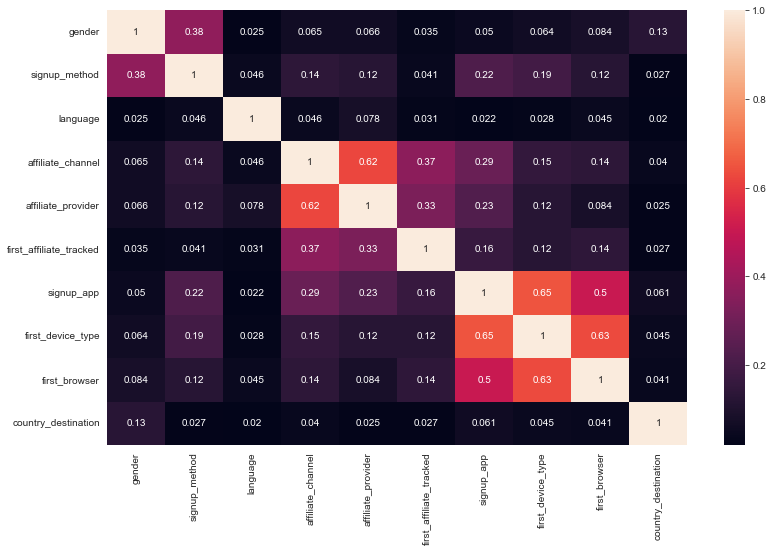

In [24]:
cat_attributes_list = cat_attributes.drop( 'id', axis=1 ).columns.tolist()

corr_dict = {}
for i in range( len ( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v( cat_attributes[ ref ], cat_attributes[ feat ] )
        
        # append a list
        corr_list.append( corr )
    
    # appende a correlation list for each ref attributs
    corr_dict[ ref ] = corr_list

d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns)
sns.heatmap( d, annot=True )

### 1.8.2 Sessions 

In [25]:
# df_sessions
cat_attributes_sessions.drop( 'user_id', axis=1 ).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


<AxesSubplot:>

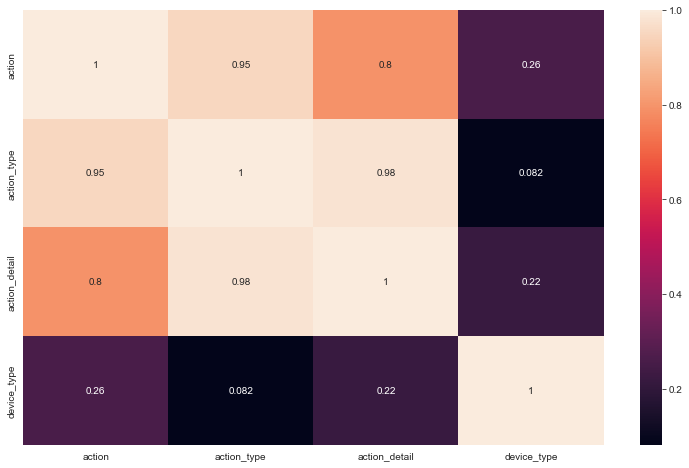

In [26]:
cat_attributes_list = cat_attributes_sessions.drop( 'user_id', axis=1 ).columns.tolist()

corr_dict = {}
for i in range( len ( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v( cat_attributes_sessions[ ref ], cat_attributes_sessions[ feat ] )
        
        # append a list
        corr_list.append( corr )
    
    # appende a correlation list for each ref attributs
    corr_dict[ ref ] = corr_list

d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns)
sns.heatmap( d, annot=True )

# 2.0. Featue Engineeging 

In [ ]:
df2.shape

In [27]:
df2 = df_raw.copy()

In [28]:
df2.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 2.1. Create New Features

In [37]:
# days from first active uo to first booking
df2['first_active'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime('%Y-%m-%d' ) )
df2['days_from_first_active_until_booking'] = ( df2['date_first_booking'] - df2['first_active'] ).apply( lambda x: x.days )

# days from first active up to account created
df2['days_from_first_active_until_account_created'] = ( df2['date_account_created'] - df2['first_active'] ).apply( lambda x: x.days )

# days from account created up to first booking 
df2['days_from_account_created_until_first_booking'] = ( df2['date_first_booking'] - df2['date_account_created'] ).apply( lambda x: x.days )

# ============== active ==============
# year of first active
df2['year_first_active'] = df2['first_active'].dt.year

# month of first active
df2['month_first_active'] = df2['first_active'].dt.month

# day of first active
df2['day_first_active'] = df2['first_active'].dt.day

# day of week
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

# week of year of first active
df2['week_first_active'] = df2['first_active'].dt.isocalendar().week.astype( 'int64' )


# ============== booking ==============
# year of first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

# month of first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

# day of first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

# day of week
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

# week of year of first booking
df2['week_first_booking'] = df2['date_first_booking'].dt.isocalendar().week.astype('int64')

# ============== Account created ==============
# year of  account_created
df2['year_account_created'] = df2['date_account_created'].dt.year

# month of  account_created
df2['month_account_created'] = df2['date_account_created'].dt.month

# day of  account_created
df2['day_account_created'] = df2['date_account_created'].dt.day

# day of week
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

# week of year of  account_created
df2['week_account_created'] = df2['date_account_created'].dt.isocalendar().week.astype('int64')

In [38]:
df2.shape

(207386, 35)

# 3.0. Data Filtering

In [39]:
df3 = df2.copy()

## 3.1. Rows

In [40]:
# there are few people with these ages and inside the dataset there is lots of weird values od age.
df3 = df3[( df3['age'] > 15 ) & ( df3['age'] <120 )]

# df_sessions = df_sessions[df_sessions['secs_elapsed'] > 0]

## 3.2. Columns 

In [45]:
# dropping columns which was used to create new columns
cols = ['date_account_created','timestamp_first_active','date_first_booking','first_active']
df3.drop( cols, axis=1, inplace=True )

# 4.0. EDA

In [46]:
df4 = df3.copy()

# 5.0. Data Preparation 

In [47]:
df5 = df4.copy()

In [69]:
# encoder
on = OneHotEncoder()

# numerical
col_num = df5.select_dtypes( include=['int64','float64'] ).columns.tolist()

# categorical
col_cat = df5.select_dtypes( exclude=['int64','float64','datetime64[ns]'] ).drop( ['id','country_destination'], axis=1 ).columns.tolist()

# encoding
df5_dummy = pd.DataFrame( on.fit_transform( df4[col_cat]).toarray(), index=df5.index )

# join numerical and categorical
df52 = pd.concat( [df5[col_num], df5_dummy], axis=1 )

## 5.1. Balanced Dataset

### 5.1. Random Undersampling

In [57]:
# ratio balanded (it's need to set all the variable to run well)
ratio_balanced = {'NDF': 1000}
undersampling = under_sampling.RandomUnderSampler( sampling_strategy=ratio_balanced, random_state=32 )

# difine sample
undersampling = under_sampling.RandomUnderSampler( sampling_strategy='auto', random_state=32 )

# apply sampler
x_under, y_under = undersampling.fit_resample( df5, df5['country_destination'] )

### 5.2. Random Oversampling 

In [59]:
# difine sample
oversampling = over_sampling.RandomOverSampler( sampling_strategy='auto', random_state=32 )

# apply sampler
x_over, y_over = oversampling.fit_resample( df5, df5['country_destination'] )

In [60]:
df5['country_destination'].value_counts()

NDF      119807
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

In [62]:
y_over.value_counts()

NDF      119807
US       119807
other    119807
CA       119807
FR       119807
ES       119807
GB       119807
IT       119807
PT       119807
NL       119807
DE       119807
AU       119807
Name: country_destination, dtype: int64

### 5.3. SMOTE + Tomeklink

In [79]:
40000/9935

4.026170105686965

In [80]:
df5['country_destination'].value_counts().to_dict()

{'NDF': 119807,
 'US': 60800,
 'other': 9935,
 'FR': 4881,
 'IT': 2776,
 'GB': 2285,
 'ES': 2203,
 'CA': 1385,
 'DE': 1033,
 'NL': 746,
 'AU': 526,
 'PT': 213}

In [86]:
ratio = {'NDF': 119807,
 'US': 60800,
 'other': 6*9935,
 'FR': 12*4881,
 'IT': 20*2776,
 'GB': 30*2285,
 'ES': 30*2203,
 'CA': 40*1385,
 'DE': 45*1033,
 'NL': 80*746,
 'AU': 85*526,
 'PT': 200*213}

ratio

{'NDF': 119807,
 'US': 60800,
 'other': 59610,
 'FR': 58572,
 'IT': 55520,
 'GB': 68550,
 'ES': 66090,
 'CA': 55400,
 'DE': 46485,
 'NL': 59680,
 'AU': 44710,
 'PT': 42600}

In [ ]:
# difine
smt = SMOTETomek( sampling_strategy=ratio, random_state=32, n_jobs=-1 )

# apply
x_smt, y_smt = smt.fit_resample( df52, df4['country_destination'] )

C:\Users\Marcos\Projects\airbnb_prediction\venv\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
# numerical data
df53 = x_smt[ col_num ]

# categorical data
df54 = x_smt.drop( col_num, axis=1 )
df55 = pd.DataFrame( ohe.inverse_transform( df44 ), columns=col_cat, index=df44.index )

# join numerical categorical
df56 = pd.concat( [df52, df55], axis=1 )
df56['country_destination'] = y_smt

In [141]:
df5_dummys = pd.get_dummies( df5.drop( ['id','country_destination'], axis=1 ) )

df5 = pd.concat( [ df5[['id','country_destination']], df5_dummys], axis=1 )

In [142]:
df5.shape

(206593, 156)

# 6.0. Feature Selection

In [143]:
df6 = df5.copy()

In [144]:
df6.columns

Index(['id', 'country_destination', 'date_account_created',
       'timestamp_first_active', 'date_first_booking', 'age', 'signup_flow',
       'first_active', 'days_from_frist_active_until_booking',
       'days_from_first_active_until_account_created',
       ...
       'first_browser_SeaMonkey', 'first_browser_Silk',
       'first_browser_SiteKiosk', 'first_browser_SlimBrowser',
       'first_browser_Sogou Explorer', 'first_browser_Stainless',
       'first_browser_TenFourFox', 'first_browser_TheWorld Browser',
       'first_browser_Yandex.Browser', 'first_browser_wOSBrowser'],
      dtype='object', length=156)

In [146]:
X = df6.drop( ['id','country_destination'], axis=1 )
y = df6['country_destination'].copy()

# 7.0. Machine Learning

In [147]:
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=32 )

## 7.1. Baseline model

In [148]:
index = df5['country_destination'].value_counts().index
values = df5['country_destination'].value_counts( normalize=True ).values

In [149]:
yhat_random = random.choices( population=index, weights=values, k=y_val.shape[0] )

In [150]:
# prediction prepare
y_val_random = y_val.to_numpy()

  model  Accuracy  BalancedAccuracy  KappaScore
0    NN     0.426             0.082       0.001
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       265
          DE       0.00      0.00      0.00       234
          ES       0.01      0.01      0.01       385
          FR       0.02      0.03      0.02       971
          GB       0.01      0.01      0.01       457
          IT       0.01      0.01      0.01       553
         NDF       0.58      0.58      0.58     23927
          NL       0.00      0.00      0.00       143
          PT       0.00      0.00      0.00        54
          US       0.30      0.29      0.29     12249
       other       0.05      0.05      0.05      1980

    accuracy                           0.43     41319
   macro avg       0.08      0.08      0.08     41319
weighted avg       0.43      0.43      0.43     41319



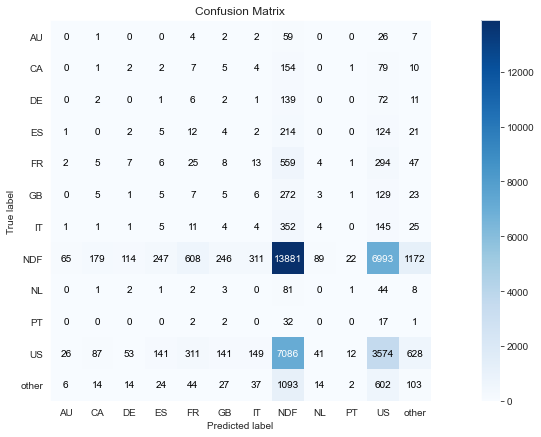

In [151]:
# balanced accuracy, accuracy, kappa score 
dic = {
    'model': 'NN',
    'Accuracy': accuracy_score( y_val_random, yhat_random ),
    'BalancedAccuracy': balanced_accuracy_score( y_val_random, yhat_random ),
    'KappaScore': cohen_kappa_score( y_val_random, yhat_random )
}
print( pd.DataFrame( dic, index=[0] ) )
print( classification_report( y_val_random, yhat_random ) )

# confusion matrix
plot_confusion_matrix(y_val_random, yhat_random, figsize=(18,7) );

## 7.2. NN 

In [152]:
on = OneHotEncoder()
y_train_nn = on.fit_transform( y_train.values.reshape(-1,1) ).toarray()

In [156]:
print( 'Number of Rows: {}'.format( X_train.shape[0] ) )
print( 'Number of Features: {}'.format( X_train.shape[1] ) )
print( 'Number of Classes: {}'.format( y_train.nunique() ) )

Number of Rows: 165274
Number of Features: 150
Number of Classes: 12


In [157]:
# model definition
model = models.Sequential()
model.add( layers.Dense( 256, input_dim=X_train.shape[1], activation='relu' ) )
model.add( layers.Dense( 12, activation='softmax' ) )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( X_train, y_train_nn, epochs=100, verbose=0 )

# 8.0. Model Performance 

In [158]:
# prediction
pred_nn = model.predict( X_val )

# invert prediction
yhat_nn =  on.inverse_transform( pred_nn )

# prediction prepare
y_val_nn = y_val.to_numpy()
yhat_nn = yhat_nn.reshape( 1,-1 )[0]

  model  Accuracy  BalancedAccuracy  KappaScore
0    NN     0.875             0.167       0.769


C:\Users\Marcos\Projects\airbnb_prediction\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Marcos\Projects\airbnb_prediction\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Marcos\Projects\airbnb_prediction\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       265
          DE       0.00      0.00      0.00       234
          ES       0.00      0.00      0.00       385
          FR       0.00      0.00      0.00       971
          GB       0.00      0.00      0.00       457
          IT       0.00      0.00      0.00       553
         NDF       1.00      1.00      1.00     23927
          NL       0.00      0.00      0.00       143
          PT       0.00      0.00      0.00        54
          US       0.70      1.00      0.83     12249
       other       0.00      0.00      0.00      1980

    accuracy                           0.88     41319
   macro avg       0.14      0.17      0.15     41319
weighted avg       0.79      0.88      0.82     41319



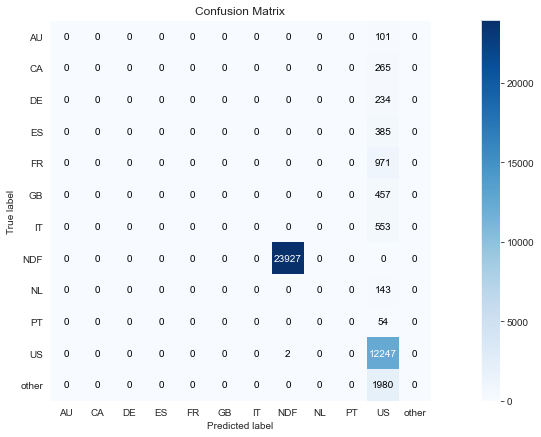

In [159]:
# balanced accuracy, accuracy, kappa score 
dic = {
    'model': 'NN',
    'Accuracy': accuracy_score( y_val_nn, yhat_nn ),
    'BalancedAccuracy': balanced_accuracy_score( y_val_nn, yhat_nn ),
    'KappaScore': cohen_kappa_score( y_val_nn, yhat_nn )
}
print( pd.DataFrame( dic, index=[0] ) )
print( classification_report( y_val_nn, yhat_nn ) )

# confusion matrix
plot_confusion_matrix(y_val_nn, yhat_nn, figsize=(18,7) );

## 8.1. Cross Validation 

In [ ]:
# generate k-fold
num_folds = 5
kfold = StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1

for train_ix, val_ix in kfold.split( X_train, y_train ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    X_train_fold = X_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = X_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding
    ohe = OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = models.Sequential()
    model.add( layers.Dense( 256, input_dim=X_train.shape[1], activation='relu' ) )
    model.add( layers.Dense( 11, activation='softmax') )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( X_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

print(f'Avg Balanced Accuracy: {np.mean( balanced_acc_list )} +/- {np.std( balanced_acc_list )}' )
print(f'Avg Kappa: {np.mean( kappa_acc_list )} +/- {np.std( kappa_acc_list )}' )